In [17]:
import jax.numpy as jnp
from jax import grad, hessian, jacobian, vmap, random
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def get_rbf(gamma):
    def kernel(x, y):
        return jnp.exp(-gamma*jnp.sum((x-y)**2))
    return kernel

def get_lap(f, argnums):
    def laplacian(x, y):
        return jnp.trace(hessian(f, argnums=argnums)(x, y))
    return laplacian

k = get_rbf(gamma=0.5)

In [19]:
lapx = get_lap(k, argnums=0) # laplacian wrt to first input x
bilap = get_lap(lapx, argnums=1) # laplacian wrt to second input y

# I want them to work on batches, but need all to go to all. So one to all, then all to one..?
vec_k = vmap(vmap(k, in_axes = (None,0)), in_axes=(0, None)) 
vec_lapx = vmap(vmap(lapx, in_axes = (None,0)), in_axes=(0, None)) 
vec_bilap = vmap(vmap(bilap, in_axes = (None,0)), in_axes = (0, None))

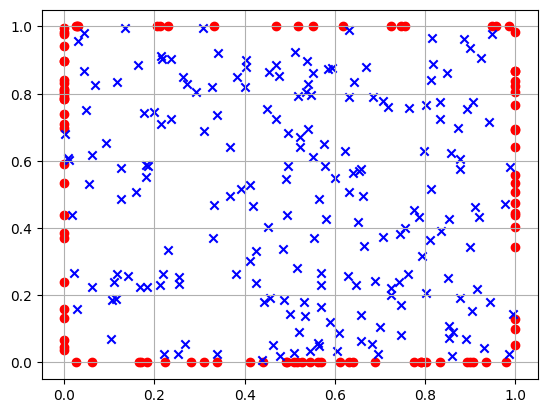

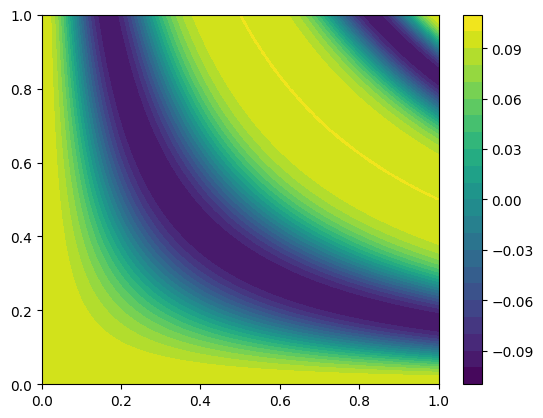

In [20]:
I = 200
B = 100
n_grid = 500
p = 0.5

key1 = random.PRNGKey(0)
key2 = random.PRNGKey(1)

X_I = random.uniform(key1, shape=(I, 2))
bd1 = jnp.concatenate((random.bernoulli(key1, p=p, shape=(B//2, 1)), random.uniform(key2, shape=(B//2, 1))), axis=1)
bd2 = jnp.concatenate((random.uniform(key1, shape=(B//2, 1)), random.bernoulli(key2, p=p, shape=(B//2, 1))), axis=1)
X_B = jnp.concatenate((bd1, bd2), axis=0)


plt.figure(1)
plt.grid()
plt.scatter(X_B[:, 0], X_B[:, 1], color='red', marker='o')
plt.scatter(X_I[:, 0], X_I[:, 1], color='blue', marker='x')

x = jnp.linspace(0, 1, n_grid)
y = jnp.linspace(0, 1, n_grid)
X, Y = jnp.meshgrid(x, y)

def f(x, y):
    return 0.1*jnp.cos(2*np.pi*jnp.sin(np.pi*x*y))

plt.figure(2)
plt.scatter(X, Y, s=0.1)
plt.contourf(X, Y, f(X, Y), levels=20)
plt.colorbar()



Setup $K \alpha = y$

In [21]:
# Should be f(x_1), ... f(x_B) and then on boundary
f_I = f(X_I[:, 0], X_I[:, 1])
f_B = jnp.zeros((X_B.shape[0],))
f_vec = jnp.hstack([f_I, f_B])
print(f_vec.shape)

(300,)


In [22]:
K_II = vec_bilap(X_I, X_I)
K_IB = vec_lapx(X_I, X_B)
K_BI = jnp.copy(K_IB).T
K_BB = vec_k(X_B, X_B)

print("K_II:", K_II.shape)
print("K_IB:", K_IB.shape)
print("K_BI:", K_BI.shape)
print("K_BB:", K_BB.shape)

K = jnp.block([
     [K_II, K_IB],
     [K_BI, K_BB]
    ])

alpha = jnp.linalg.solve(K + 0.01*jnp.eye(K.shape[0]), f_vec)

cond_K = jnp.linalg.cond(K)
new_cond_K = jnp.linalg.cond(K + 0.01*jnp.eye(K.shape[0]))
improvement = cond_K//new_cond_K 

print(f"Condition number of K is {cond_K}")
print(f"Condition number of regularized K is {new_cond_K}")
print(f"Improvement: {improvement}")


K_II: (200, 200)
K_IB: (200, 100)
K_BI: (100, 200)
K_BB: (100, 100)
Condition number of K is 72599879680.0
Condition number of regularized K is 107061.8125
Improvement: 678111.0


Solution is given by $u(x) = \bm{\phi}(K(x, \cdot)) K_{\phi\phi}^{-1} y = \bm{\phi}(K(x, \cdot)) \bm{\alpha}$. However, we would like to compute solution on more than one point at a time, say at $\mathcal{X}_{\textrm{test}} = \{x_i\}$. This becomes $$u(\mathcal{X}_{\textrm{test}}) = \bm{\phi}(K(\mathcal{X}_{\textrm{test}}, \cdot)) K_{\phi\phi}^{-1} y$$

In our case, we obtain $$ u(x) = \sum_{i = 1}^{|I|} \Delta_1 K(x_i, x) + \sum_{j = |I| + 1}^{|I| + |B|} K(x_j, x)$$

So having solved for the coefficients $\bm{\alpha}$, it remains to vectorize the basis. 

In [23]:
def u(x):
    basis = jnp.hstack([vec_lapx(x.reshape(1, -1), X_I), vec_k(x.reshape(1, -1), X_B)])
    return (basis @ alpha).squeeze()

vec_u = vmap(u, in_axes=0)

And check solution. 

In [24]:
def check_lap(u):
    def lap(x):
        return jnp.trace(hessian(u)(x))
    return vmap(lap, in_axes=0)

N_GRID = 110
x, y = jnp.linspace(0, 1, N_GRID), jnp.linspace(0, 1, N_GRID)
X, Y = jnp.meshgrid(x, y)

X_test = jnp.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)

print(X_test.shape)

lap_u = check_lap(u)
lap_u_test = lap_u(X_test)

(12100, 2)


(0.0, 1.0)

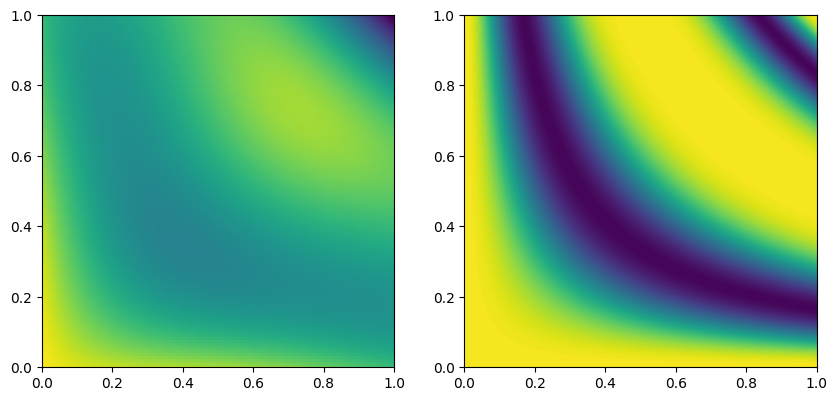

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].scatter(X_test[:, 0], X_test[:,1], c = lap_u_test)
axs[1].contourf(X, Y, f(X, Y), levels=100)
axs[0].set_aspect('equal', 'box')
axs[1].set_aspect('equal', 'box')
axs[0].set_xlim([x.min(), x.max()])
axs[0].set_ylim([y.min(), y.max()])
axs[1].set_xlim([x.min(), x.max()])
axs[1].set_ylim([y.min(), y.max()])

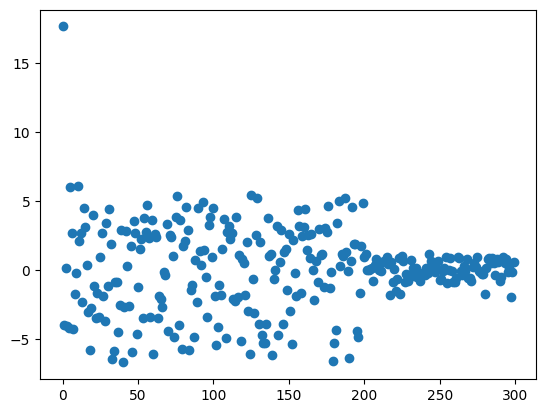

In [26]:
plt.scatter(jnp.arange(alpha.shape[0]), alpha)

c:\Users\Owner\Desktop\GaussianProcesses\venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Owner\Desktop\GaussianProcesses\venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


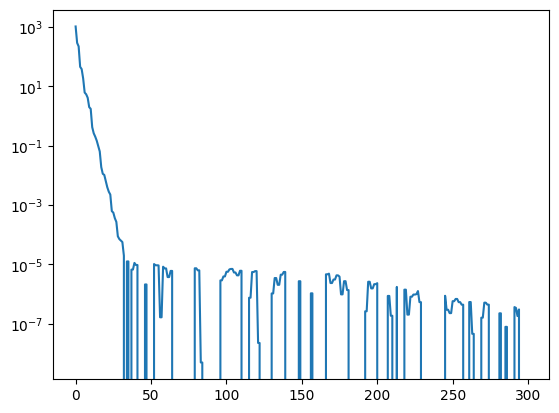

In [ ]:
spectra = jnp.linalg.eigvals(K)

plt.plot(spectra)
